In [1]:
import numpy as np
import math 



def data_regularize(data, type="spheric", divs = 10):
    limits = np.array([
        [min(data[:,0]), max(data[:,0])],
        [min(data[:,1]), max(data[:,1])],
        [min(data[:,2]), max(data[:,2])]])
        
    regularized = []

    if type=="cubic":
        
        X = np.linspace(*limits[0], num = divs)
        Y = np.linspace(*limits[1], num = divs)
        Z = np.linspace(*limits[2], num = divs)

        for i in range(divs-1):
            for j in range(divs-1):
                for k in range(divs-1):
                    points_in_sector = []
                    for point in data:
                        if (point[0] >= X[i] and point[0] < X[i+1] and
                            point[1] >= Y[j] and point[1] < Y[j+1] and
                            point[2] >= Z[k] and point[2] < Z[k+1]) :
                            
                            points_in_sector.append(point)
                    if len(points_in_sector) > 0:
                        regularized.append(np.mean(np.array(points_in_sector), axis=0))

    elif type=="spheric" :
        divs_u = divs 
        divs_v = divs * 2

        center = np.array([
            0.5 * (limits[0,0] + limits[0,1]),
            0.5 * (limits[1,0] + limits[1,1]),
            0.5 * (limits[2,0] + limits[2,1])])
        d_c = data - center
    
        #spherical coordinates around center
        r_s = np.sqrt(d_c[:,0]**2. + d_c[:,1]**2. + d_c[:,2]**2.)
        d_s = np.array([
            r_s,
            np.arccos(d_c[:,2] / r_s),
            np.arctan2(d_c[:,1], d_c[:,0])]).T

        u = np.linspace(0, np.pi, num = divs_u)
        v = np.linspace(-np.pi, np.pi, num = divs_v)

        for i in range(divs_u - 1):
            for j in range(divs_v - 1):
                points_in_sector = []
                for k , point in enumerate(d_s):
                    if (point[1] >= u[i] and point[1] < u[i+1] and 
                        point[2] >= v[j] and point[2] < v[j+1]) :

                        points_in_sector.append(data[k])

                if len(points_in_sector) > 0:
                    regularized.append(np.mean(np.array(points_in_sector), axis=0))

### Other strategy of finding mean values in sectors

##                    p_sec = np.array(points_in_sector)
##                    R = np.mean(p_sec[:,0])

##                    U = (u[i] + u[i+1])*0.5
##                    V = (v[j] + v[j+1])*0.5
##                    x = R*math.sin(U)*math.cos(V)
##                    y = R*math.sin(U)*math.sin(V)
##                    z = R*math.cos(U)
##                    regularized.append(center + np.array([x,y,z]))
    

    return np.array(regularized)



# https://github.com/minillinim/ellipsoid
def ellipsoid_plot(center, radii, rotation, ax, plotAxes=False, cageColor='b', cageAlpha=0.2):
    """Plot an ellipsoid"""
        
    u = np.linspace(0.0, 2.0 * np.pi, 100)
    v = np.linspace(0.0, np.pi, 100)
    
    # cartesian coordinates that correspond to the spherical angles:
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
    # rotate accordingly
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center

    if plotAxes:
        # make some purdy axes
        axes = np.array([[radii[0],0.0,0.0],
                         [0.0,radii[1],0.0],
                         [0.0,0.0,radii[2]]])
        # rotate accordingly
        for i in range(len(axes)):
            axes[i] = np.dot(axes[i], rotation)


        # plot axes
        for p in axes:
            X3 = np.linspace(-p[0], p[0], 100) + center[0]
            Y3 = np.linspace(-p[1], p[1], 100) + center[1]
            Z3 = np.linspace(-p[2], p[2], 100) + center[2]
            ax.plot(X3, Y3, Z3, color=cageColor)

    # plot ellipsoid
    ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color=cageColor, alpha=cageAlpha)



# http://www.mathworks.com/matlabcentral/fileexchange/24693-ellipsoid-fit
# for arbitrary axes
def ellipsoid_fit(X):
    x=X[:,0]
    y=X[:,1]
    z=X[:,2]
    D = np.array([x*x,
                 y*y,
                 z*z,
                 2 * x*y,
                 2 * x*z,
                 2 * y*z,
                 2 * x,
                 2 * y,
                 2 * z])
    DT = D.conj().T
    v = np.linalg.solve( D.dot(DT), D.dot( np.ones( np.size(x) ) ) )
    A = np.array(  [[v[0], v[3], v[4], v[6]],
                    [v[3], v[1], v[5], v[7]],
                    [v[4], v[5], v[2], v[8]],
                    [v[6], v[7], v[8], -1]])

    center = np.linalg.solve(- A[:3,:3], [[v[6]],[v[7]],[v[8]]])
    T = np.eye(4)
    T[3,:3] = center.T
    R = T.dot(A).dot(T.conj().T)
    evals, evecs = np.linalg.eig(R[:3,:3] / -R[3,3])
    radii = np.sqrt(1. / evals)

    # calculate difference of the fitted points from the actual data normalized by the conic radii
    sgns = np.sign(evals);
    radii = radii * sgns;
    d = np.array([x - center[0], y - center[1], z - center[2]]); # shift data to origin
    d = np.asarray(np.matrix(d.T) * np.matrix(evecs)); # rotate to cardinal axes of the conic;
    d = np.array([d[:,0] / radii[0], d[:,1] / radii[1], d[:,2] / radii[2]]).T; # normalize to the conic radii
    chi2 = np.sum(np.abs(1 - np.sum(d**2 * np.tile(sgns, (d.shape[0], 1)), axis=1)));

    return center, radii, evecs, v, chi2
 

In [2]:
data = np.loadtxt("data.txt")
data2 = data_regularize(data)

center, radii, evecs, v, chi2 = ellipsoid_fit(data2)
center,radii,evecs,v,chi2

(array([[ -66.87877887],
        [  80.5369075 ],
        [-131.23767547]]),
 array([192.25124825, 170.2361731 , 162.73062578]),
 array([[-0.2012162 ,  0.97439392, -0.10034209],
        [ 0.8223291 ,  0.22369264,  0.52319829],
        [-0.53224702, -0.02276175,  0.84628306]]),
 array([ 1.88606548e-04,  1.67244557e-04,  1.91308805e-04,  5.84927824e-06,
        -5.91880697e-06,  2.59062853e-05,  1.13659224e-02, -9.67828621e-03,
         2.26246681e-02]),
 5.165434714092173)

In [3]:
q=np.loadtxt('data.txt')

In [77]:
#import numpy as np
#from ellipsoid_fit import ellipsoid_fit as ellipsoid_fit, data_regularize




data = np.loadtxt("cal.txt")
data2 = data_regularize(data,divs=4)

center, radii, evecs, v, chi2 = ellipsoid_fit(data2)

a,b,c = radii
r = (a*b*c)**(1./3.)
D = np.array([[r/a,0.,0.],[0.,r/b,0.],[0.,0.,r/c]])
TR = evecs.dot(D).dot(evecs.T)

print('residual:', chi2)
print('center: ',center)
print('transformation:')
print(TR)

np.savetxt('result.txt', np.vstack((center.T, TR)))
 

residual: 0.7939399352730901
center:  [[-12.37496667]
 [ -2.46630628]
 [-71.20278138]]
transformation:
[[0.96110737 0.02040064 0.01421182]
 [0.02040064 1.0410413  0.01091945]
 [0.01421182 0.01091945 1.00018223]]


Traceback (most recent call last):
  File "c:\program files\python38\lib\site-packages\matplotlib\cbook\__init__.py", line 196, in process
    func(*args, **kwargs)
  File "c:\program files\python38\lib\site-packages\matplotlib\animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


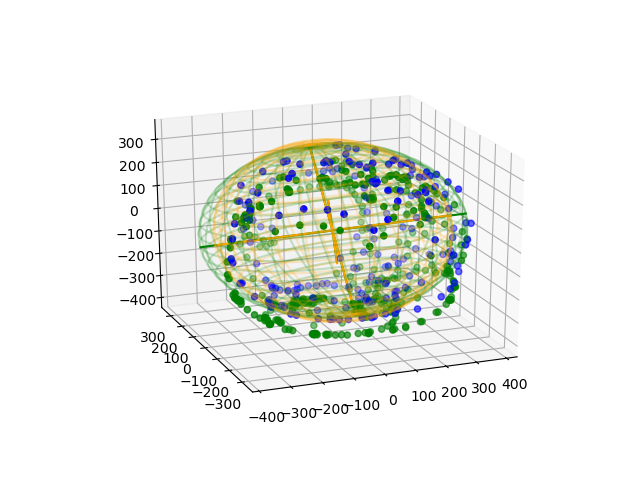

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

data = np.loadtxt("cal.txt")
data2 = data_regularize(data,divs=20)

center, radii, evecs, v, chi2 = ellipsoid_fit(data2)

dataC = data - center.T
dataC2 = data2 - center.T

a,b,c = radii
r = (a*b*c)**(1./3.)#preserve volume?
D = np.array([[r/a,0.,0.],[0.,r/b,0.],[0.,0.,r/c]])
#http://www.cs.brandeis.edu/~cs155/Lecture_07_6.pdf
#affine transformation from ellipsoid to sphere (translation excluded)
TR = evecs.dot(D).dot(evecs.T)
dataE = TR.dot(dataC2.T).T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


#hack  for equal axes
#ax.set_aspect('equal')
MAX = 200
for direction in (-1, 1):
    for point in np.diag(direction * MAX * np.array([1,1,1])):
        ax.plot([point[0]], [point[1]], [point[2]], 'w')

ax.scatter(data[:,0], data[:,1], data[:,2], marker='o', color='g')
ax.scatter(dataC2[:,0], dataC2[:,1], dataC2[:,2], marker='o', color='b')
#ax.scatter(dataE[:,0], dataE[:,1], dataE[:,2], marker='o', color='r')

ellipsoid_plot([0,0,0], radii, evecs, ax=ax, plotAxes=True, cageColor='g')
ellipsoid_plot([0,0,0], [r,r,r], evecs,ax=ax, plotAxes=True,cageColor='orange')

#ax.plot([r],[0],[0],color='r',marker='o')
#ax.plot([radii[0]],[0],[0],color='b',marker='o')
#print np.array([radii[0],0,0]).dot(transform)[0], r

plt.show()



In [18]:
import plotly.graph_objects as go
import numpy as np

# Helix equation
t = np.linspace(0, 10, 50)
x, y, z = dataC2[:,0],dataC2[:,1],dataC2[:,2]

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers')])
fig.show()

In [15]:
dataC2[:10]

array([[-20.71050828,  -6.61489997, 164.50116605],
       [ -2.71050828, -41.61489997, 167.50116605],
       [  4.28949172, -15.61489997, 167.50116605],
       [ 26.28949172, -28.61489997, 166.50116605],
       [ 65.28949172, -23.61489997, 154.50116605],
       [ 52.28949172,   1.38510003, 151.50116605],
       [ 33.78949172,  14.88510003, 162.00116605],
       [ 34.28949172,  37.38510003, 151.50116605],
       [ 20.28949172,  55.88510003, 155.50116605],
       [ -2.71050828,  35.71843337, 159.83449938]])

In [32]:
!pip3 install ws4py

    Running setup.py install for ws4py: started
    Running setup.py install for ws4py: finished with status 'done'


You should consider upgrading via the 'c:\program files\python38\python.exe -m pip install --upgrade pip' command.


In [6]:
from websocket import create_connection
ws = create_connection("ws://192.168.2.199:80")
print("Sending 'Hello, World'...")
ws.send("Hello, World")
print("Sent")
print("Receiving...")
result =  ws.recv()
print("Received '%s'" % result)
ws.close()

Sending 'Hello, World'...
Sent
Receiving...
Received '377.199697,115.919983,-89.239988'


<IPython.core.display.Javascript object>


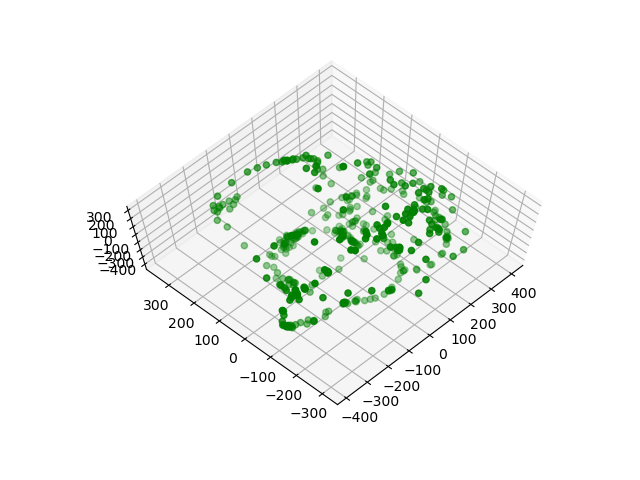

In [74]:
import time
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import datetime
import matplotlib.dates as mdates
from collections import deque
import numpy as np

import serial
import re

import websocket

websocket.enableTrace(False)
ws = websocket.WebSocket()
ws.connect("ws://192.168.2.199:80")
#ws.send("Hello, Server")




HISTORY_SIZE=2000    
INTERVAL = 0.01    
# Deque for axes
mag_x = deque(maxlen=HISTORY_SIZE)
mag_y = deque(maxlen=HISTORY_SIZE)
mag_z = deque(maxlen=HISTORY_SIZE)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# fig, ax = plt.subplots(1, 1,projection='3d')
#ax.set_aspect(1)

# close port in case its open

serialport = None
anim = None

count=0

def onClick(event):
    anim.event_source.stop()
    
def animate(i):
    global count
    print("animate",i)
    recv=None
    while recv==None:
        recv= ws.recv()
        if recv!=None:
            ret=[float(ii) for ii in recv.split(',')]
            print(recv,ret)
            count+=1
    #ret = imu_data[count]
    
    if ret:

        x, y, z = ret
        mag_x.append(x)
        mag_y.append(y)
        mag_z.append(z)

        # Clear all axis
        ax.cla()

        # Display the sub-plots
    ax.scatter(mag_x,mag_y, mag_z, marker='o', color='g')

#     ax.scatter(mag_x, mag_y, color='r')
#     ax.scatter(mag_y, mag_z, color='g')
#     ax.scatter(mag_z, mag_x, color='b')

    if len(mag_x) == HISTORY_SIZE:
            print("length reached")
            anim.event_source.stop()
        # Pause the plot for INTERVAL seconds 
    plt.pause(INTERVAL)

fig.canvas.mpl_connect('button_press_event', onClick)    
anim = FuncAnimation(fig, animate)


In [79]:
plt.show()

In [75]:
xx=[i for i in mag_x]
yy=[i for i in mag_y]
zz=[i for i in mag_z]
f=open("cal.txt",'w')
print(len(xx))
for i in range(len(xx)):
    f.write("%f %f %f\n"%(xx[i],yy[i],zz[i]))
f.close()

454


In [78]:
ws.close()

In [36]:
websocket.enableTrace(True)
ws = websocket.WebSocket()
ws.connect("ws://192.168.2.199:80")
#ws.send("Hello, Server")

while True:
    try:
        recv=None
        while recv==None:
            recv= ws.recv()
            print(recv)

    except KeyboardInterrupt:
        ws.close()
        break

--- request header ---
GET / HTTP/1.1
Upgrade: websocket
Host: 192.168.2.199
Origin: http://192.168.2.199
Sec-WebSocket-Key: uA3DhJjSsjej9kVXTmuXIw==
Sec-WebSocket-Version: 13
Connection: Upgrade


-----------------------
--- response header ---
HTTP/1.1 101 Switching Protocols
Upgrade: websocket
Connection: Upgrade
Sec-WebSocket-Accept: efaTtz8e2FWPlPCrEopx1Ypx5b8=
-----------------------


373.519897,66.239991,-158.239865
372.599721,72.679992,-146.279964
376.279902,74.519992,-145.359859
375.359845,76.359987,-145.359859
377.199697,77.280002,-143.519950
376.279902,76.359987,-143.519950
375.359845,78.199983,-142.599974
376.279902,79.119997,-139.839959
377.199697,77.280002,-138.919985
376.279902,69.919982,-149.039974
376.279902,70.839996,-149.959955
374.439931,68.079987,-151.799860
374.439931,69.000001,-151.799860
373.519897,66.239991,-153.639946
373.519897,69.000001,-153.639946
372.599721,65.319977,-155.479860
372.599721,62.560000,-156.399965
371.679807,63.479996,-158.239865
374.439931,61.640000,-157.319999
373.519897,69.919982,-150.880003
377.199697,73.599977,-148.119869
373.519897,73.599977,-147.199955
375.359845,73.599977,-144.439878
375.359845,74.519992,-148.119869
376.279902,76.359987,-145.359859
376.279902,75.440001,-145.359859
372.599721,68.079987,-154.559875
375.359845,78.199983,-138.919985
377.199697,76.359987,-140.759945
374.439931,70.839996,-149.039974


send: b'\x88\x82d\xae\xafNgF'


In [11]:
import websocket



def on_message(wsapp, message):
    global value
    value=[float(i) for i in message.split(',')]
    print(message)
    
    
wsapp = websocket.WebSocketApp("ws://192.168.2.199:80", on_message=on_message)
wsapp.run_forever()

--- request header ---
GET / HTTP/1.1
Upgrade: websocket
Host: 192.168.2.199
Origin: http://192.168.2.199
Sec-WebSocket-Key: oGQWJK80K5LNcoIeM5fDKw==
Sec-WebSocket-Version: 13
Connection: Upgrade


-----------------------
--- response header ---
HTTP/1.1 101 Switching Protocols
Upgrade: websocket
Connection: Upgrade
Sec-WebSocket-Accept: LSEM8no43mICgNYCJkrBAkNk8UI=
-----------------------


375.359845,122.359979,-45.999999
378.119874,122.359979,-45.080004
374.439931,122.359979,-58.879991
373.519897,125.119996,-59.799991
374.439931,125.119996,-59.799991
377.199697,125.119996,-58.879991
376.279902,126.039970,-57.959991
376.279902,125.119996,-58.879991
373.519897,125.119996,-57.959991
379.959702,120.519984,-45.999999
375.359845,123.280001,-57.039995
377.199697,124.199975,-55.200000
375.359845,120.519984,-41.399994
377.199697,119.599974,-38.640001
377.199697,118.679989,-39.559999
376.279902,119.599974,-39.559999
378.119874,119.599974,-37.720001
376.279902,118.679989,-37.720001
378.119874,120.519984,-36.799989
378.119874,119.599974,-37.720001
378.119874,118.679989,-35.879991
377.199697,118.679989,-36.799989
377.199697,122.359979,-46.919999
375.359845,122.359979,-51.519990
375.359845,123.280001,-49.679995
377.199697,123.280001,-52.439990
376.279902,124.199975,-53.360000
377.199697,123.280001,-54.280000
376.279902,124.199975,-54.280000
377.199697,121.440005,-55.200000
380.879879

send: b'\x88\x82v\xb4\xbf\xbbu\\'


False